# NYC Metro Database Forecast

## Table of Contents:
* [1. Imports](#imports)
* [2. Forecasting](#forecasting)
    * [2.1. Prophet](#prophet)
        * [2.1.1. Total traffic forecast](#prophet-1)
        * [2.1.2. Forecast by stations and lines](#prophet-2)
    * [2.2. XGBoost](#xgboost)
        * [2.2.1. Total traffic forecast](#xgboost-1)
        * [2.2.2. Forecast by stations and lines](#xgboost-2)
* [3. Summary of results](#summary)
* [4. Conclusion](#conclusion)

# 1. Imports <a class="anchor" id="imports"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

**Loading the dataset**

In [2]:
DATASET_FOLDER = 'dataset'

STATION_TEST = '121 ST'

LINE_TEST = '2345ACJZ'

# Dataframe with traffic by station and day
df_st = pd.read_csv(os.path.join(DATASET_FOLDER, 'daily_traffic_by_station.csv'), parse_dates=["datetime"])

# Dataframe with traffic by linename and day
df_ln = pd.read_csv(os.path.join(DATASET_FOLDER, 'daily_traffic_by_line.csv'), parse_dates=["datetime"])

# Dataframe with the total traffic by day
df_tot = df_ln.groupby('datetime').traffic.sum().reset_index()

# 2. Forecasting <a class="anchor" id="forecasting"></a>

## 2.1. Prophet <a class="anchor" id="prophet"></a>

Forecasting procedure developed by Facebook. [webpage](https://facebook.github.io/prophet/)

### 2.1.1 Total traffic forecast <a class="anchor" id="prophet-1"></a>

Splits data into training and validation

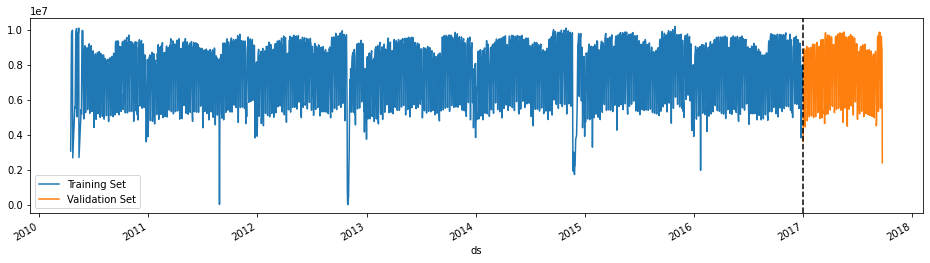

In [3]:
df_tot = df_tot.rename(columns={'datetime':'ds', 'traffic':'y'})

df_train = df_tot[df_tot.ds < '2017-01-01']
df_val = df_tot[~(df_tot.ds < '2017-01-01')]

# Plot
fig, ax = plt.subplots(figsize=(16, 4))
df_train.set_index('ds').plot(ax=ax)
df_val.set_index('ds').plot(ax=ax)
ax.axvline('2017-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Validation Set'])
plt.show()

Fitting Prophet model on training data (years: 2010 ~ 2017)

In [4]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df_train)

20:36:05 - cmdstanpy - INFO - Chain [1] start processing
20:36:05 - cmdstanpy - INFO - Chain [1] done processing


Predicting future values (year: >2017)

In [5]:
# Forecasting
future = m.make_future_dataframe(periods=len(df_val), include_history=False)
forecast = m.predict(future)

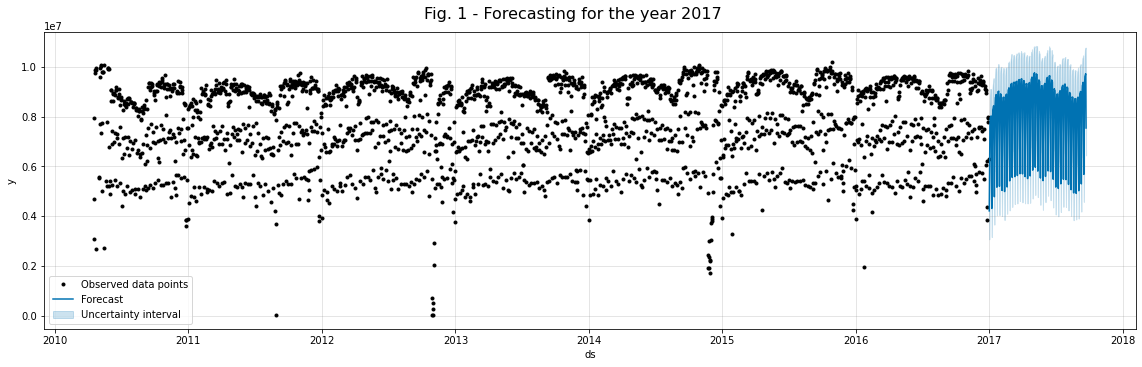

In [6]:
m.plot(forecast, figsize=(16, 5), include_legend=True).suptitle('Fig. 1 - Forecasting for the year 2017', size=16, y=1.01);

**descrever alguma coisa sobre a figura acima aqui**

Plot the time series components

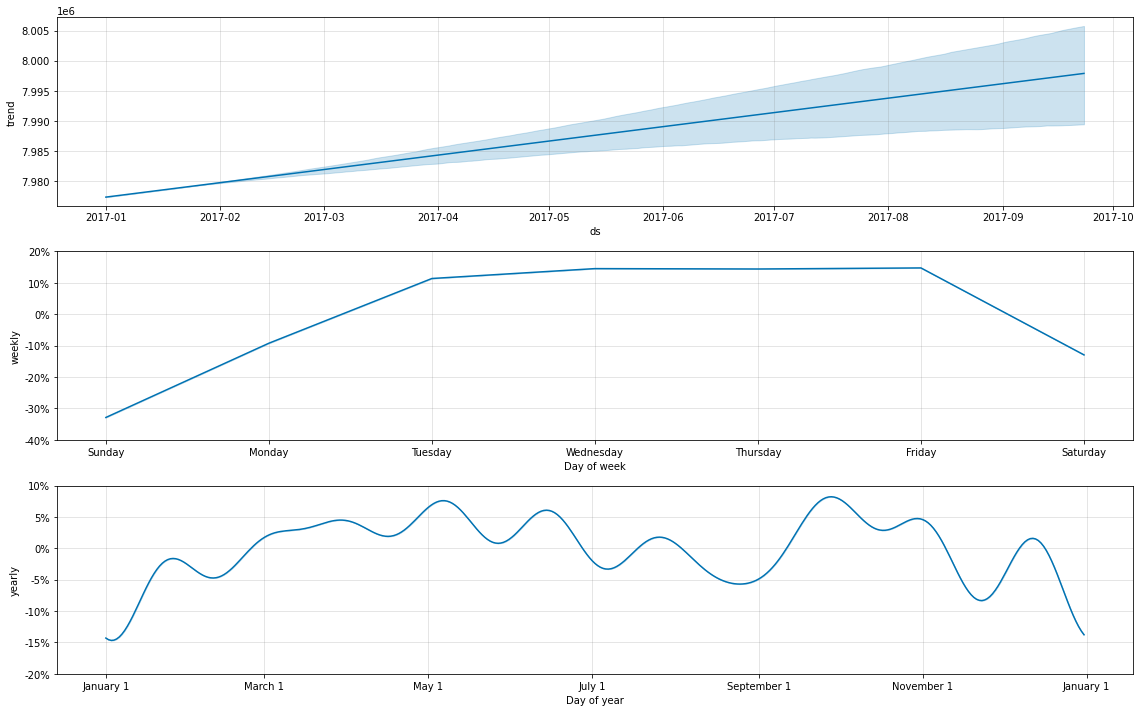

In [7]:
fig2 = m.plot_components(forecast, figsize=(16, 10))

#### Evaluating results

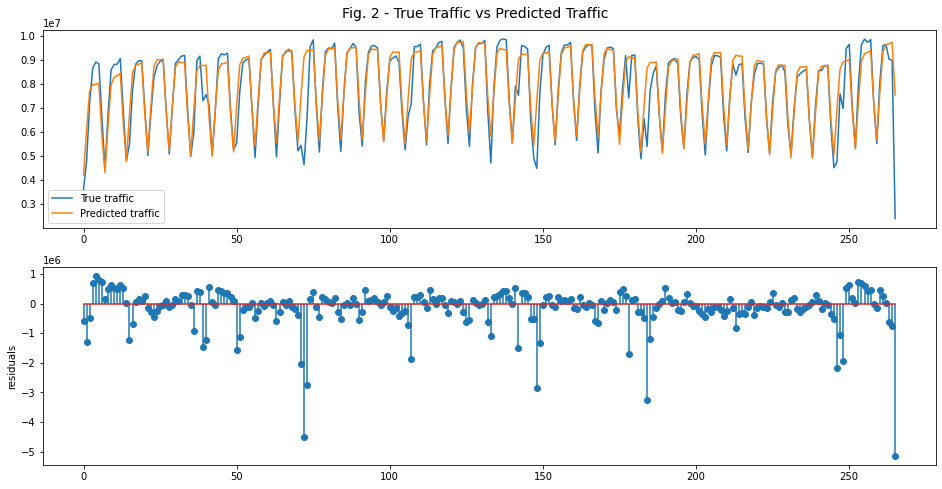

In [10]:
y_true = df_val.y.values
y_pred = forecast.yhat.values

fig, ax = plt.subplots(2, 1, figsize=(16, 8))
ax[0].plot(np.vstack((y_true, y_pred)).transpose())
ax[0].legend(['True traffic', 'Predicted traffic'])

ax[1].stem(range(len(y_true)), y_true-y_pred_prophet)
ax[1].set_ylabel('residuals')
plt.suptitle('Fig. 2 - True Traffic vs Predicted Traffic', y=0.92, size=14)
plt.show()

In [11]:
def compute_ts_metrics(y_true, y_pred):
    """
    Compute and print a set of metrics to evaluate the predicted values.
    """
    mape = metrics.mean_absolute_percentage_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = metrics.mean_squared_error(y_true, y_pred, squared=False)

    print("Metrics")
    print("----------------")
    print("MAPE : %.4f" % (mape))
    print("MAE  : %.2f" % (mae))
    print("RMSE : %.2f" % (rmse))
    
compute_ts_metrics(y_true, y_pred)

Metrics
----------------
MAPE : 0.0630
MAE  : 387532.12
RMSE : 714247.47


**descrever alguma coisa sobre a figura acima aqui**

#### Running cross validation to measure method performance.

In [12]:
def validate_model(m, df):
    # Fit model
    m.fit(df.rename(columns={'datetime':'ds', 'traffic':'y'}))
    
    # Run cross validation
    initial = f"{(df_tot.ds<'2013-01-01').sum()} days"
    df_cv = cross_validation(m, initial=initial, period='365 days', horizon = '365 days', disable_tqdm=True, parallel='processes')

    # Compute performance metrics
    df_p = performance_metrics(df_cv)
    
    return df_cv, df_p


def plot_cv_results(df_cv, metric):
    return plot_cross_validation_metric(df_cv, metric=metric, rolling_window=0.02, figsize=(16, 5))

In [13]:
m = Prophet()
df_cv, df_p = validate_model(m, df_tot)
df_p.describe()

20:37:14 - cmdstanpy - INFO - Chain [1] start processing
20:37:15 - cmdstanpy - INFO - Chain [1] done processing
20:37:15 - cmdstanpy - INFO - Chain [1] start processing
20:37:15 - cmdstanpy - INFO - Chain [1] start processing
20:37:15 - cmdstanpy - INFO - Chain [1] done processing
20:37:15 - cmdstanpy - INFO - Chain [1] start processing
20:37:15 - cmdstanpy - INFO - Chain [1] start processing
20:37:15 - cmdstanpy - INFO - Chain [1] done processing
20:37:15 - cmdstanpy - INFO - Chain [1] done processing
20:37:15 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
count,329,3.290000e+02,3.290000e+02,3.290000e+02,329.000000,329.000000,329.000000,329.000000
mean,201 days 00:00:00,8.125141e+11,7.778397e+05,4.931184e+05,0.086886,0.040160,0.070446,0.913103
std,95 days 02:50:25.209861311,1.054295e+12,4.561929e+05,2.854816e+05,0.075211,0.022930,0.045563,0.065085
min,37 days 00:00:00,9.906636e+10,3.147481e+05,2.254945e+05,0.030739,0.017801,0.030264,0.732877
25%,119 days 00:00:00,2.835651e+11,5.325083e+05,3.077820e+05,0.044677,0.023953,0.041246,0.883562
50%,201 days 00:00:00,3.642300e+11,6.035147e+05,3.569982e+05,0.052218,0.027907,0.048695,0.931507
75%,283 days 00:00:00,6.636089e+11,8.146219e+05,5.699991e+05,0.083693,0.054715,0.075135,0.965753
max,365 days 00:00:00,4.011290e+12,2.002821e+06,1.232694e+06,0.307355,0.094914,0.192931,0.986301


In [14]:
m = Prophet()
m.add_country_holidays(country_name='US')
df_cv, df_p = validate_model(m, df_tot)
df_p.describe()

20:37:27 - cmdstanpy - INFO - Chain [1] start processing
20:37:27 - cmdstanpy - INFO - Chain [1] done processing
20:37:27 - cmdstanpy - INFO - Chain [1] start processing
20:37:27 - cmdstanpy - INFO - Chain [1] start processing
20:37:27 - cmdstanpy - INFO - Chain [1] start processing
20:37:27 - cmdstanpy - INFO - Chain [1] start processing
20:37:27 - cmdstanpy - INFO - Chain [1] done processing
20:37:27 - cmdstanpy - INFO - Chain [1] done processing
20:37:28 - cmdstanpy - INFO - Chain [1] done processing
20:37:28 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
count,329,3.290000e+02,3.290000e+02,3.290000e+02,329.000000,329.000000,329.000000,329.000000
mean,201 days 00:00:00,6.515324e+11,6.781505e+05,4.216902e+05,0.074721,0.033756,0.061109,0.919370
std,95 days 02:50:25.209861311,9.478007e+11,4.384388e+05,2.574499e+05,0.069539,0.019767,0.042302,0.060790
min,37 days 00:00:00,7.794666e+10,2.791893e+05,1.877903e+05,0.025618,0.015561,0.024972,0.736301
25%,119 days 00:00:00,1.660070e+11,4.074396e+05,2.644188e+05,0.037688,0.018833,0.036112,0.883562
50%,201 days 00:00:00,2.237098e+11,4.729797e+05,2.947625e+05,0.041802,0.025007,0.039496,0.945205
75%,283 days 00:00:00,5.531995e+11,7.437738e+05,4.926204e+05,0.073448,0.046361,0.069752,0.965753
max,365 days 00:00:00,3.501777e+12,1.871304e+06,1.142644e+06,0.278281,0.090099,0.176724,0.979452


After adding US holydays to the model, our average MAPE was significantly reduced from **0.0868** to **0.0747**

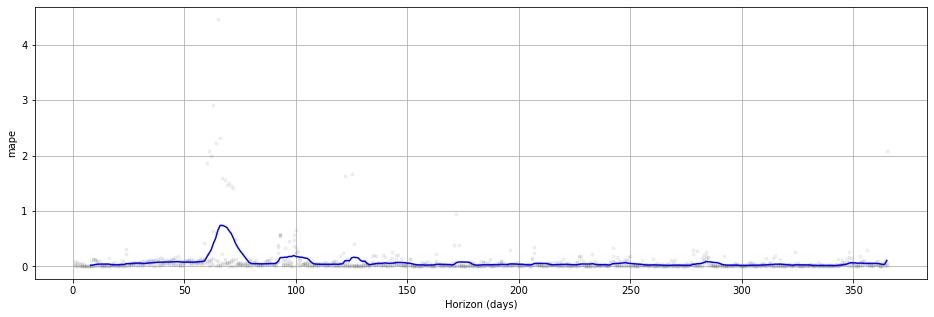

In [15]:
fig = plot_cv_results(df_cv, 'mape')

### 2.1.2. Forecast by stations and lines <a class="anchor" id="prophet-2"></a>

In [19]:
def train_and_predict_prophet(df, title):
    
    # Split dataset
    cut_date = '2017-01-01'
    df = df.rename(columns={'datetime':'ds', 'traffic':'y'})
    df = df.groupby('ds').y.sum().reset_index()
    df_train = df[df.ds < cut_date]
    df_val = df[~(df.ds < cut_date)]
    
    # Training
    m = Prophet(seasonality_mode='multiplicative')
    m.fit(df_train)

    # Forecasting
    future = m.make_future_dataframe(periods=len(df_val), include_history=True)
    forecast = m.predict(future)
    
    # Plot All time series
    fig = m.plot(forecast, figsize=(18, 4))
    ax = fig.gca().set_title(title, size=22)
    plt.plot(df_val.ds, df_val.y, color='C1')
    plt.show()
    
    # Plot only the future values
    forecast = forecast[forecast.ds>=cut_date]
    x = forecast.ds
    y_true = df_val.y.values
    y_pred = forecast.yhat.values
    
    plt.figure(figsize=(18, 4))
    plt.plot(y_pred, color='C0')
    plt.plot(y_true, color='C1')
    plt.legend(['Pred Traffic', 'True Traffic'])
    plt.show()
    
    # Compute metrics
    compute_ts_metrics(y_pred, y_true)

20:38:23 - cmdstanpy - INFO - Chain [1] start processing
20:38:23 - cmdstanpy - INFO - Chain [1] done processing


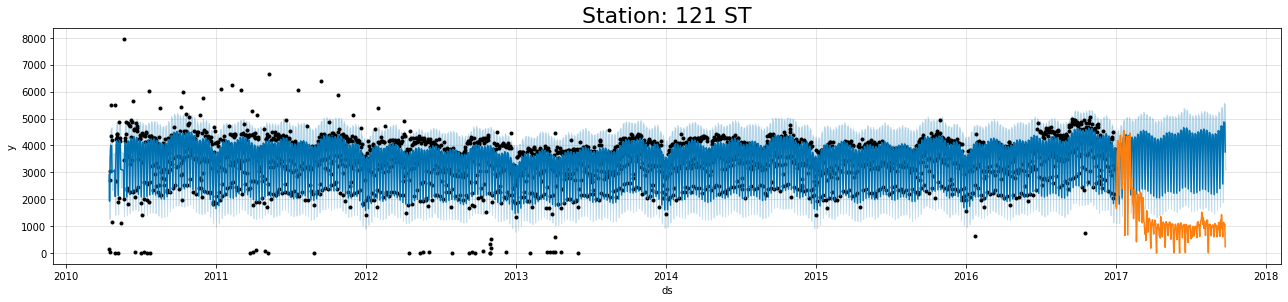

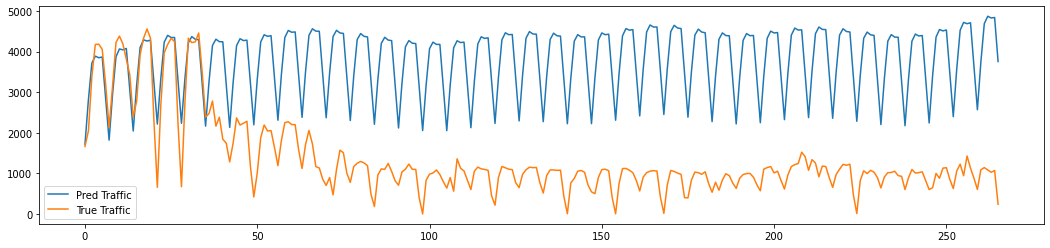

Metrics
----------------
MAPE : 0.6458
MAE  : 2446.60
RMSE : 2660.40


In [20]:
# Station
train_and_predict_prophet(df_st[df_st['station']==STATION_TEST], title=f'Station: {STATION_TEST}')

20:38:30 - cmdstanpy - INFO - Chain [1] start processing
20:38:30 - cmdstanpy - INFO - Chain [1] done processing


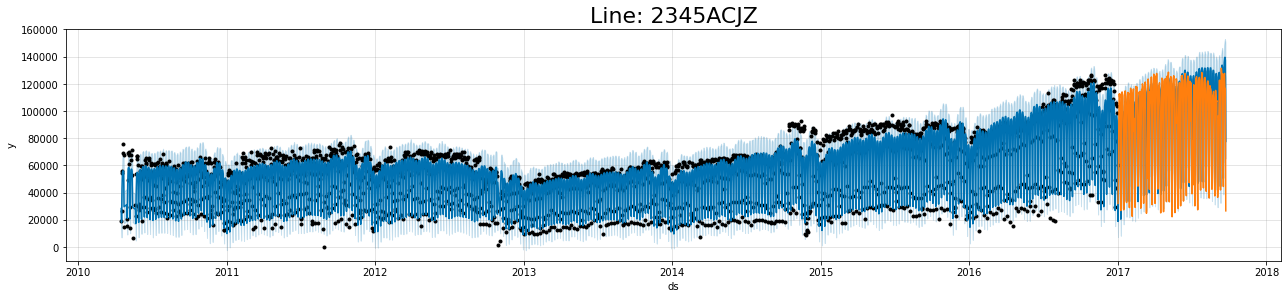

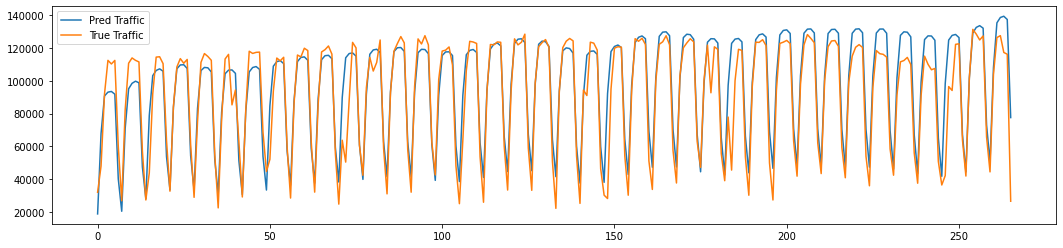

Metrics
----------------
MAPE : 0.1133
MAE  : 9172.81
RMSE : 13606.82


In [21]:
# Line
train_and_predict_prophet(df_ln[df_ln['linename']==LINE_TEST], title=f'Line: {LINE_TEST}')

## 2.2. XGBoost <a class="anchor" id="xgboost"></a>

### 2.2.1 Total traffic forecast <a class="anchor" id="xgboost-1"></a>

In [22]:
import xgboost as xgb

In [65]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['week'] = df.index.week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

train = create_features(df_train.set_index('ds'))
val = create_features(df_val.set_index('ds'))

train.head()

,y,dayofweek,dayofyear,week,quarter,month,year
ds,,,,,,,
2010-04-17,3068310.0,5,107,15,2,4,2010
2010-04-18,4701924.0,6,108,15,2,4,2010
2010-04-19,7930490.0,0,109,16,2,4,2010
2010-04-20,9762741.0,1,110,16,2,4,2010
2010-04-21,9875566.0,2,111,16,2,4,2010


In [66]:
FEATURES = ['dayofweek', 'dayofyear', 'week', 'quarter', 'month', 'year']
TARGET = 'y'

X_train, y_train = train[FEATURES], train[TARGET]
X_val, y_val = val[FEATURES], val[TARGET]

In [67]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=100)

[0]	validation_0-rmse:7904249.62547	validation_1-rmse:7925223.00737
[100]	validation_0-rmse:3000451.61598	validation_1-rmse:2960945.21321
[200]	validation_0-rmse:1272601.14619	validation_1-rmse:1208817.16525
[300]	validation_0-rmse:702232.09420	validation_1-rmse:717111.32345
[400]	validation_0-rmse:517631.07658	validation_1-rmse:633064.38082
[500]	validation_0-rmse:446315.76218	validation_1-rmse:616810.44768
[600]	validation_0-rmse:402203.07030	validation_1-rmse:617014.12432
[617]	validation_0-rmse:393908.18396	validation_1-rmse:617775.48876


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

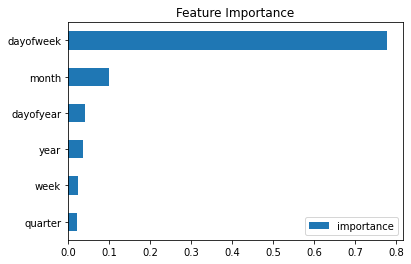

In [68]:
fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=['importance']
)

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

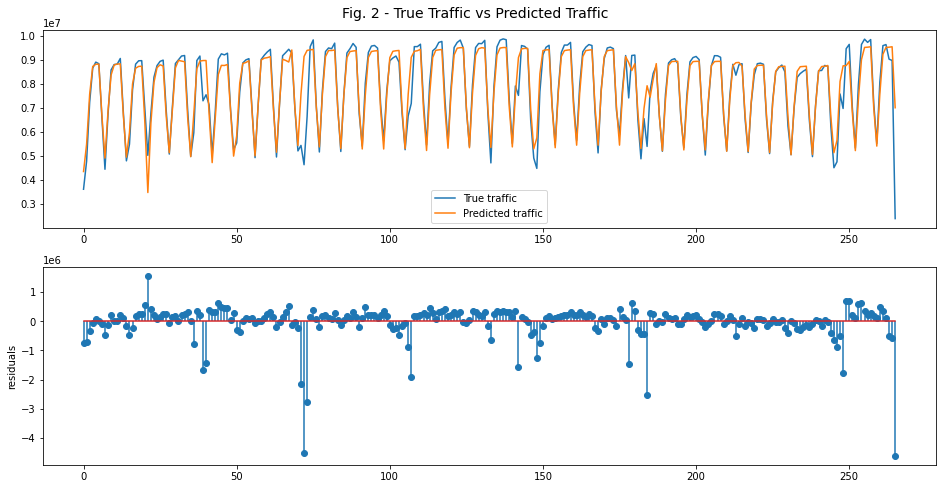

In [69]:
val['pred'] = reg.predict(X_val)

y_true = val.y.values
y_pred_xgb = val.pred.values

fig, ax = plt.subplots(2, 1, figsize=(16, 8))
ax[0].plot(np.vstack((y_true, y_pred_xgb)).transpose())
ax[0].legend(['True traffic', 'Predicted traffic'])

ax[1].stem(range(len(y_true)), y_true-y_pred_xgb)
ax[1].set_ylabel('residuals')
plt.suptitle('Fig. 2 - True Traffic vs Predicted Traffic', y=0.92, size=14)
plt.show()

In [70]:
y_true, y_pred = val.y, val.pred
mape = metrics.mean_absolute_percentage_error(y_true, y_pred)
mae = metrics.mean_absolute_error(y_true, y_pred)
rmse = metrics.mean_squared_error(y_true, y_pred, squared=False)

print("Metrics")
print("----------------")
print("MAPE : %.4f" % (mape))
print("MAE  : %.2f" % (mae))
print("RMSE : %.2f" % (rmse))

Metrics
----------------
MAPE : 0.0520
MAE  : 324114.95
RMSE : 615661.78


### 2.2.2. Forecasting by stations and lines <a class="anchor" id="xgboost-2"></a>

In [105]:
def train_and_predict_xgboost(df, title):
    
    # Split dataset
    cut_date = '2017-01-01'
    df = df.rename(columns={'datetime':'ds', 'traffic':'y'})
    df = df.groupby('ds').y.sum().reset_index()
    df_train = df[df.ds < cut_date]
    df_val = df[~(df.ds < cut_date)]

    # Create features
    train = create_features(df_train.set_index('ds'))
    val = create_features(df_val.set_index('ds'))
    
    # Split features and targets
    X_train, y_train = train[FEATURES], train[TARGET]
    X_val, y_val = val[FEATURES], val[TARGET]

    # Training
    reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01)
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=500)

    # Forecasting
    train['pred'] = reg.predict(X_train)
    val['pred'] = reg.predict(X_val)

    y_pred = val['pred']
    y_true = val['y']
    
    # Plot results
    fig, ax = plt.subplots(2, 1, figsize=(18, 9))
    ax[0].scatter(train.index, train.y, c='k', marker='.')
    ax[0].plot(train.pred, c='C0')
    ax[0].plot(y_pred, c='C0')
    ax[0].plot(y_true, c='C1')
    ax[1].plot(y_pred)
    ax[1].plot(y_true)
    plt.show()
    
    # Compute metrics
    compute_ts_metrics(y_pred, y_true)

[0]	validation_0-rmse:3529.57076	validation_1-rmse:1652.42808
[500]	validation_0-rmse:346.81780	validation_1-rmse:2406.68391
[999]	validation_0-rmse:283.88538	validation_1-rmse:2446.94034


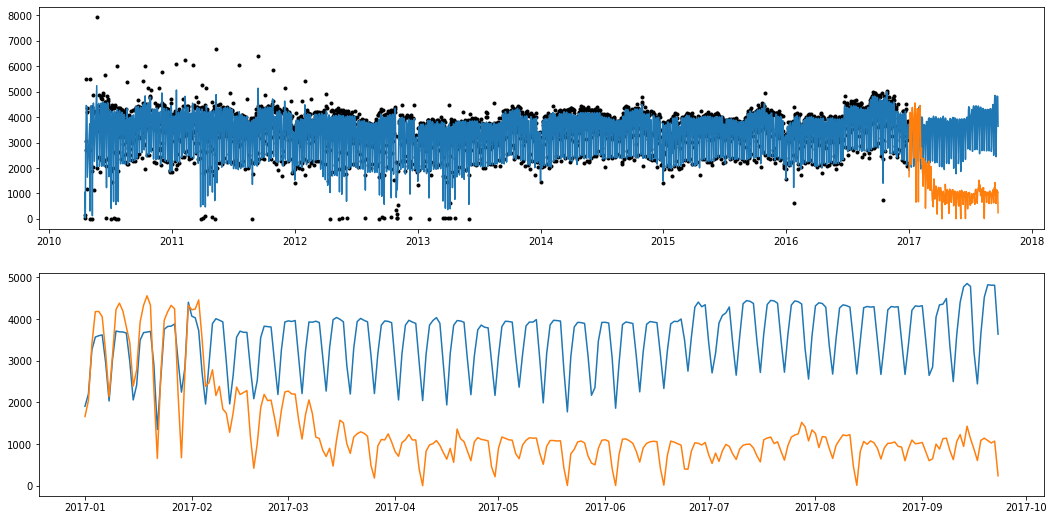

Metrics
----------------
MAPE : 0.6329
MAE  : 2256.00
RMSE : 2446.94


In [106]:
# Station
train_and_predict_xgboost(df_st[df_st['station']==STATION_TEST], title=f'Station: {STATION_TEST}')

[0]	validation_0-rmse:59675.83297	validation_1-rmse:96961.56259
[500]	validation_0-rmse:4894.51311	validation_1-rmse:23983.42106
[1000]	validation_0-rmse:3741.08071	validation_1-rmse:23321.13473
[1500]	validation_0-rmse:3197.19302	validation_1-rmse:23267.51310
[1999]	validation_0-rmse:2803.29038	validation_1-rmse:23312.05391


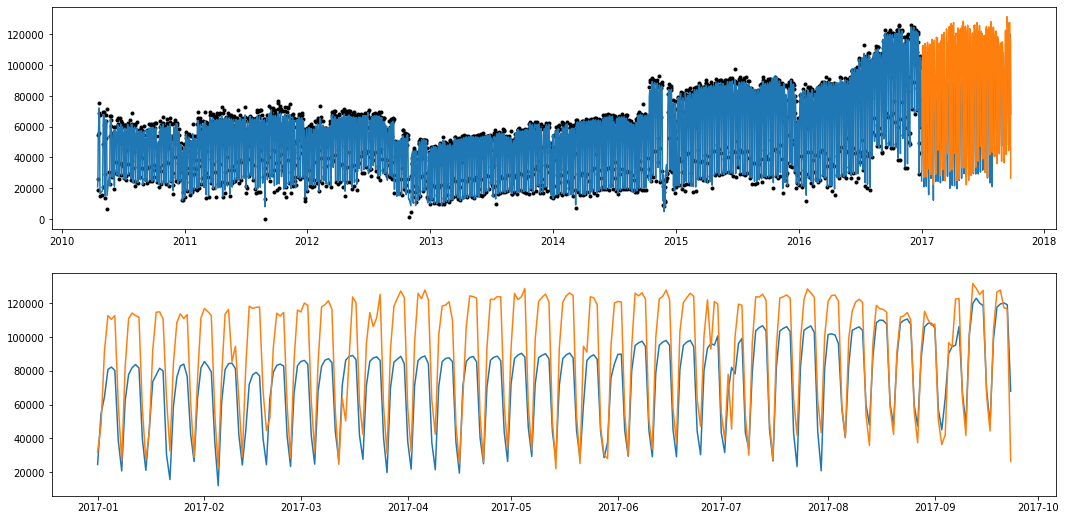

Metrics
----------------
MAPE : 0.2937
MAE  : 19982.33
RMSE : 23312.05


In [104]:
# Station
train_and_predict_xgboost(df_ln[df_ln['linename']==LINE_TEST], title=f'Line: {LINE_TEST}')

# 3. Summary of results <a class="anchor" id="summary"></a>

# 4. Conclusion <a class="anchor" id="conclusion"></a>